## Importing and exploring EEG dataset 
### Exploring epochs

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
#%matplotlib inline
#%matplotlib qt

from mayavi import mlab
#%qui qt

In [2]:
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_ePodium\\"
PATH_CODE = ROOT + "EEG_explorer\\"
PATH_DATA = ROOT + "Data\\"
PATH_OUTPUT = ROOT + "Data\\"

### Inspect occuring events for all cnt files 

In [5]:
import fnmatch
import warnings
warnings.filterwarnings('ignore')

dirs = os.listdir(PATH_DATA)
cnt_files = fnmatch.filter(dirs, "*.cnt")

# pick file:
filename = cnt_files[0]


# Import data and events
file = PATH_DATA + filename
data_raw = mne.io.read_raw_cnt(file, montage=None, eog='auto', preload=True)

# Band-pass filter (between 1 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
data_raw.filter(1, 40, fir_design='firwin')

events = mne.find_events(data_raw, shortest_event=0, stim_channel='STI 014', verbose=False)

event_id = [3, 13, 66] # select events for the given event IDs
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.8  # end of each epoch (800ms after the trigger)

baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=baseline, preload=True, verbose=False)


Reading 0 ... 370279  =      0.000 ...   740.558 secs...
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


### Pick one type of stimuli (e.g. "66") 

In [6]:
print(epochs['66'])

<Epochs  |   50 events (all good), -0.2 - 0.8 sec, baseline [None, 0], ~12.0 MB, data loaded,
 '66': 50>


### Plot average of all epochs

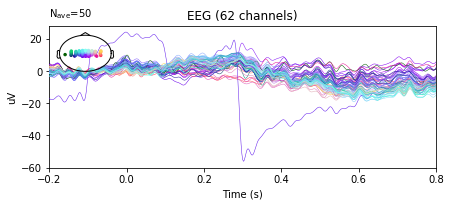

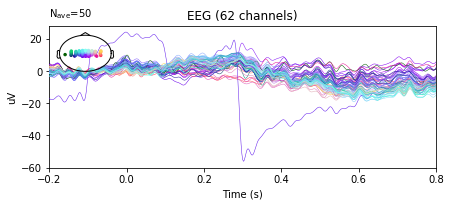

In [7]:
epochs['66'].average().plot(spatial_colors=True)

### Plot one instance of the epoch

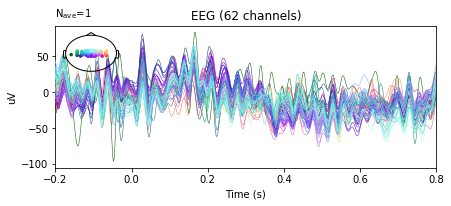

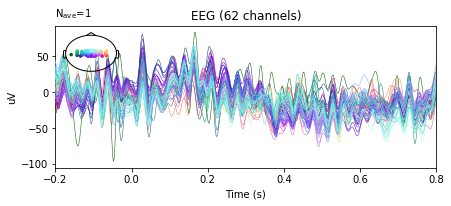

In [8]:
epochs['66'][0].average().plot(spatial_colors=True)

### Plot all individual instances of an epoch

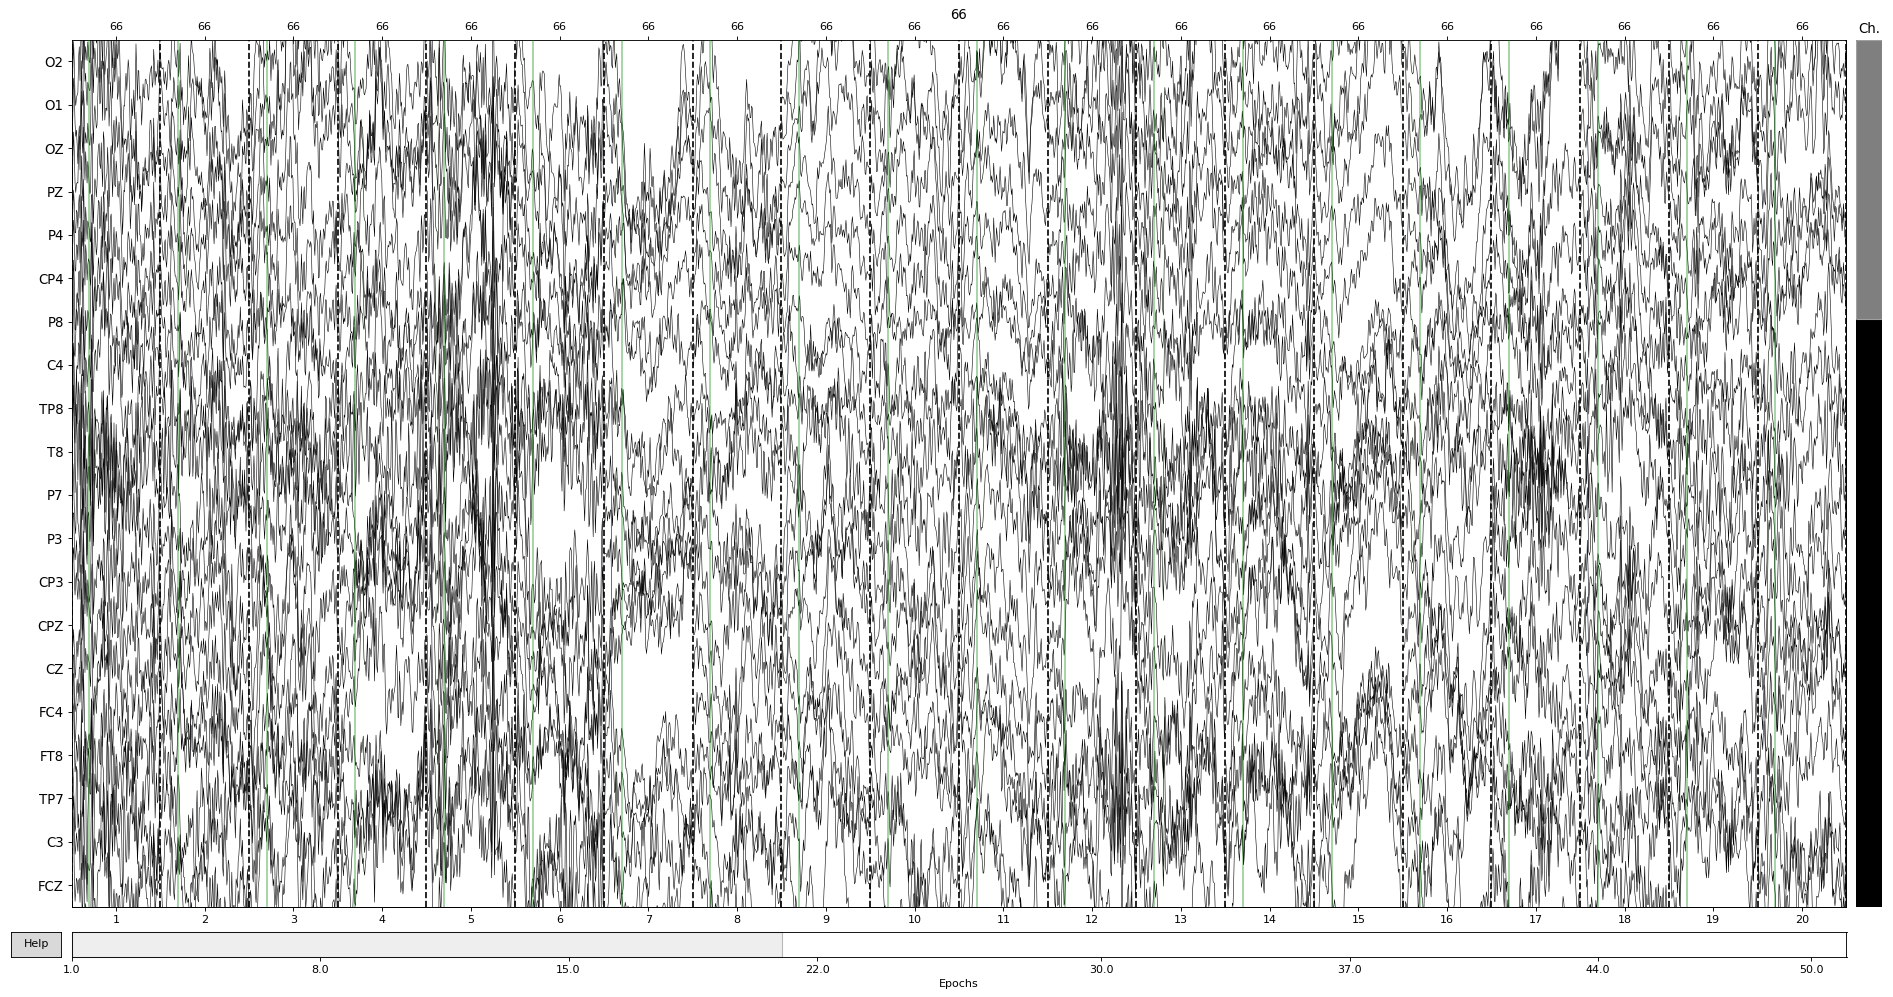

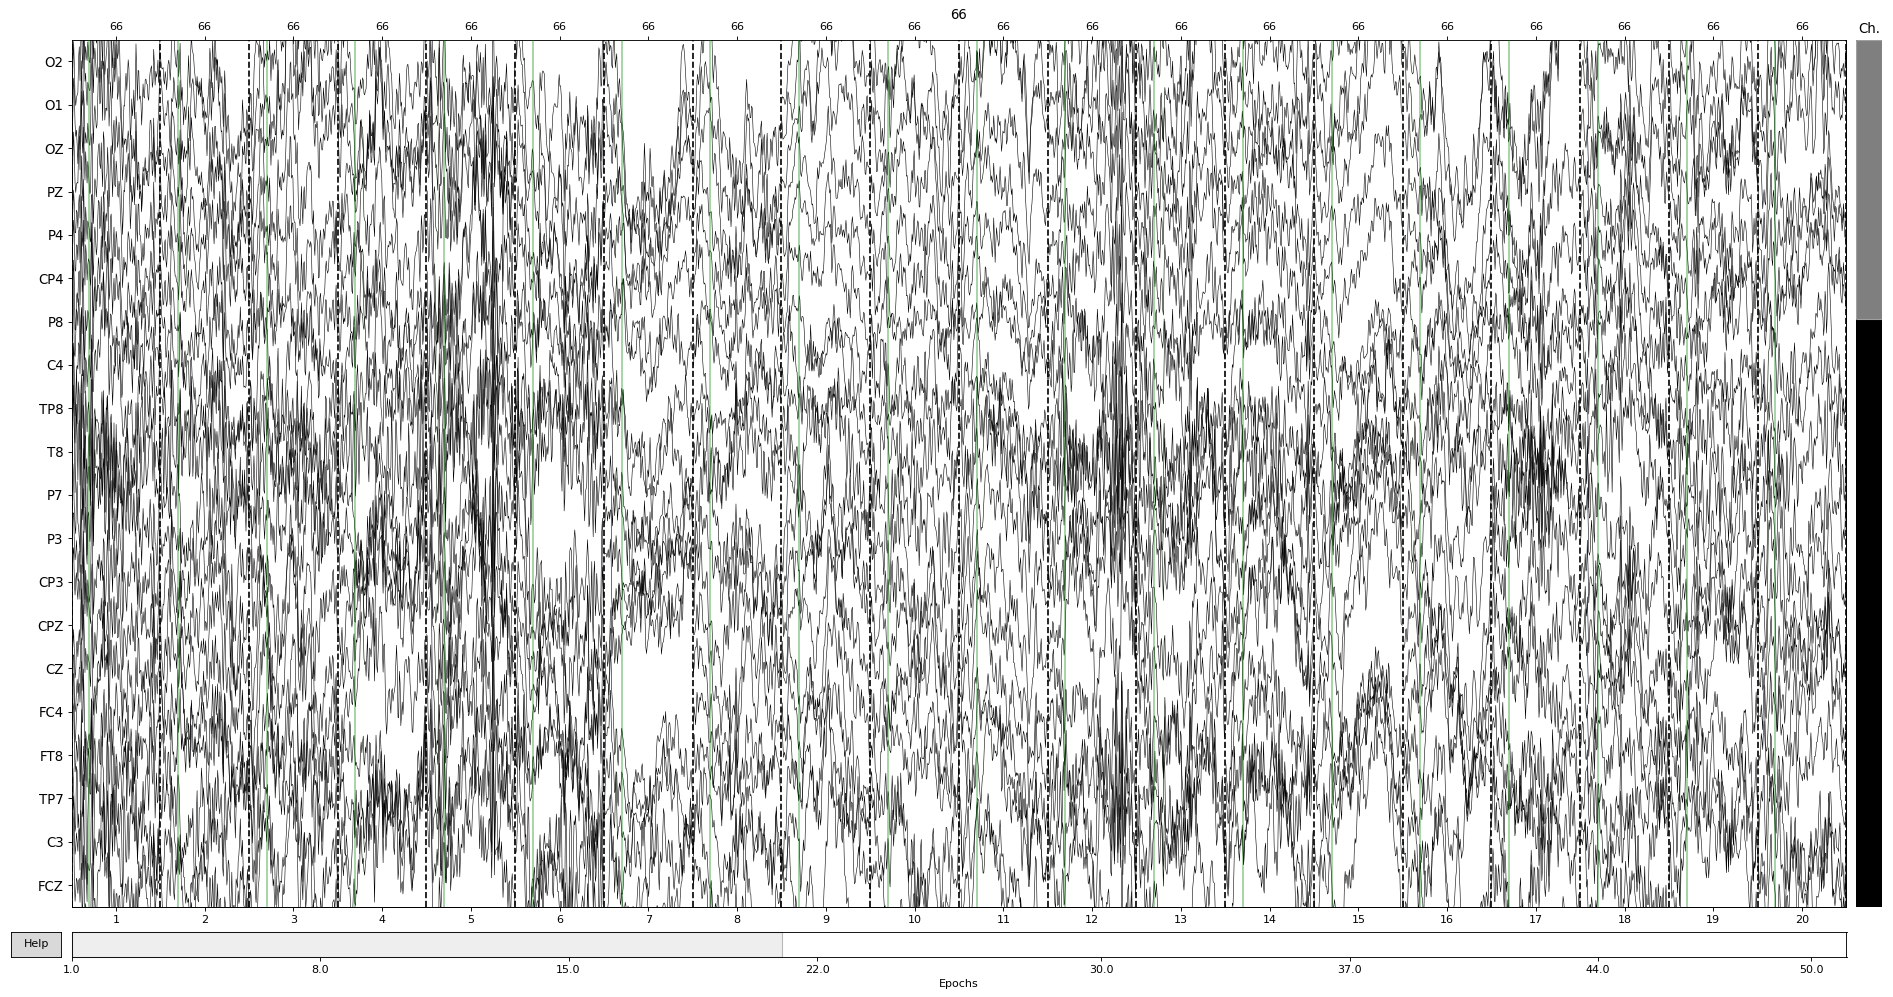

In [4]:
epochs['66'].plot()

In [16]:
total_set = total_events[0]
for set in total_events:
    total_set = total_set | set
    
print(list(total_set))

[66, 3, 2, 4, 12, 13, 14, 77, 55]


In [31]:
total_events[155]
cnt_files[155]

'730-201-17m-jr-mmn.cnt'

In [108]:
threshold = 5
max_bin = (histogram[1][np.argmax(histogram[0])+1] - histogram[1][np.argmax(histogram[0])])/2
idx = np.where(np.array(variances) > threshold*max_bin)[0][0]

print("Suspicious channel(s): ", data_raw.ch_names[idx])

Suspicious channel(s):  PO3


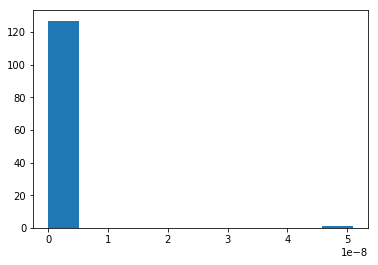

In [97]:
def plot_hist(data): 
    for i in range(data.shape[0]):
        variances.append(data[i,:].var())
    
    histogram = plt.hist(variances, 10)
    histogram[1]
    print("Suspicious channel(s): ", data_raw.ch_names[variances.index(max(variances))])
    
plot_hist(evoked.data)

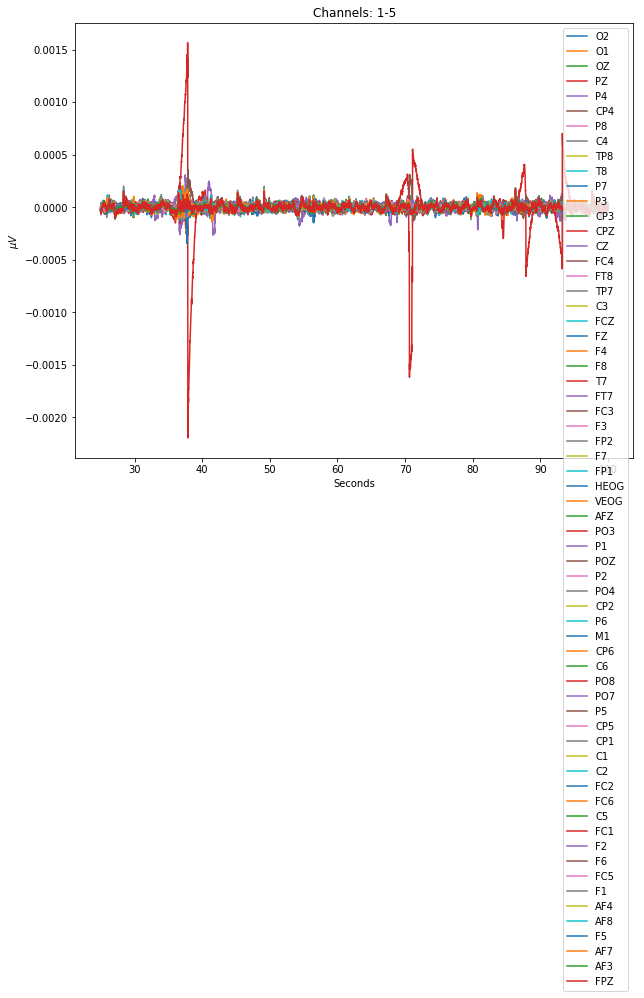

In [89]:
no_channels = 64
sfreq = data_raw.info['sfreq']
data, times = data_raw[:no_channels, int(sfreq * 25):int(sfreq * 100)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T)
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5')
plt.legend(data_raw.ch_names[:no_channels])

### Try to select 'bad' channels

Suspected bad channel:  PO3


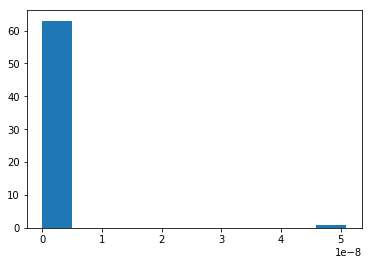

In [90]:
variances = []
for i in range(data.shape[0]):
    variances.append(data[i,:].var())
    
histogram = plt.hist(variances, 10)

idx = np.where(np.array(variances) > histogram[1][8])[0][0]
print("Suspected bad channel: ", data_raw.ch_names[idx])
#print("Suspected bad channel: ", data_raw.ch_names[variances.index(max(variances))])

In [109]:
data_raw.info['bads'] = [data_raw.ch_names[idx]]

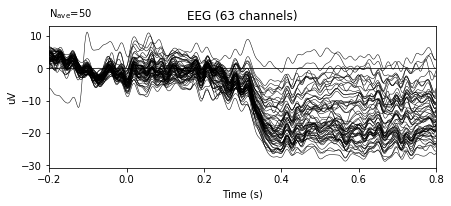

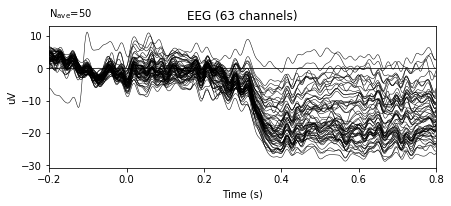

In [153]:
events = mne.find_events(data_raw, shortest_event=0, stim_channel='STI 014', verbose=False)
    
event_id = [3, 13, 66] # select events for the given event IDs
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.8  # end of each epoch (500ms after the trigger)

baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=baseline, preload=True, verbose=False)

evoked = epochs['13'].average()
evoked.plot();

# compute interpolation (also works with Raw and Epochs objects)
evoked.interpolate_bads(reset_bads=False, verbose=False)

evoked.plot();

In [128]:
epochs.event_id

{'3': 3, '13': 13, '66': 66}

400 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


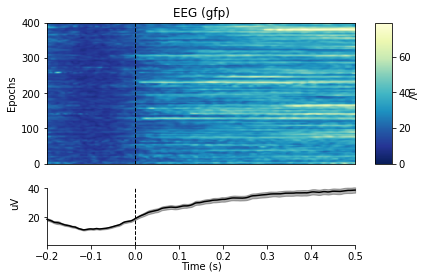

50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


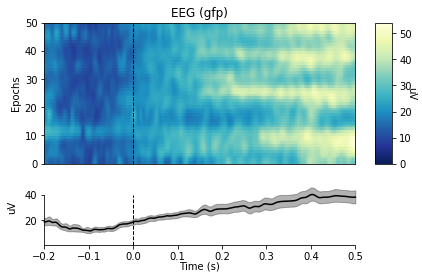

50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


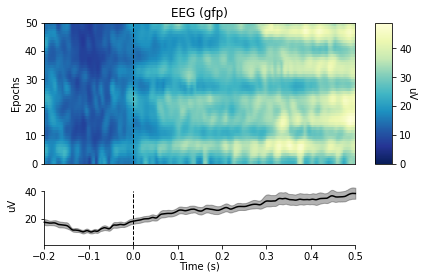

[<Figure size 432x288 with 3 Axes>]

In [127]:
epochs['3'].plot_image(combine='gfp', group_by='type', sigma=2., cmap="YlGnBu_r")
epochs['13'].plot_image(combine='gfp', group_by='type', sigma=2., cmap="YlGnBu_r")
epochs['66'].plot_image(combine='gfp', group_by='type', sigma=2., cmap="YlGnBu_r")

### Further inspect episodes after events...

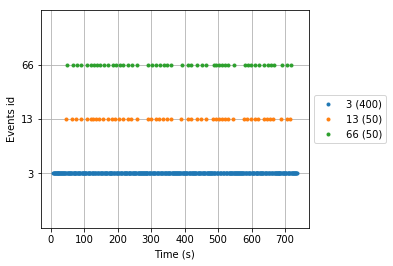

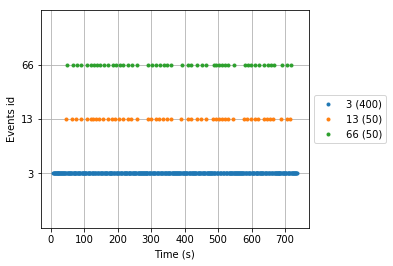

In [140]:
mne.viz.plot_events(events, data_raw.info['sfreq'], data_raw.first_samp, event_id=epochs.event_id)

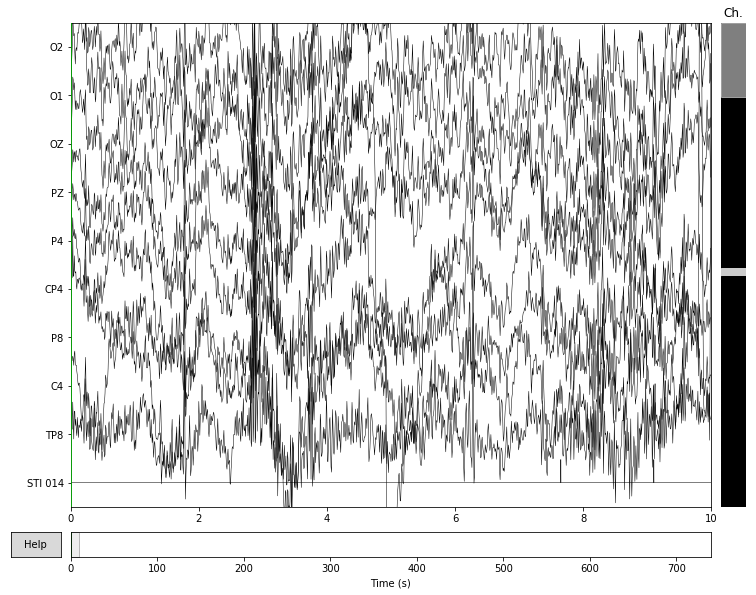

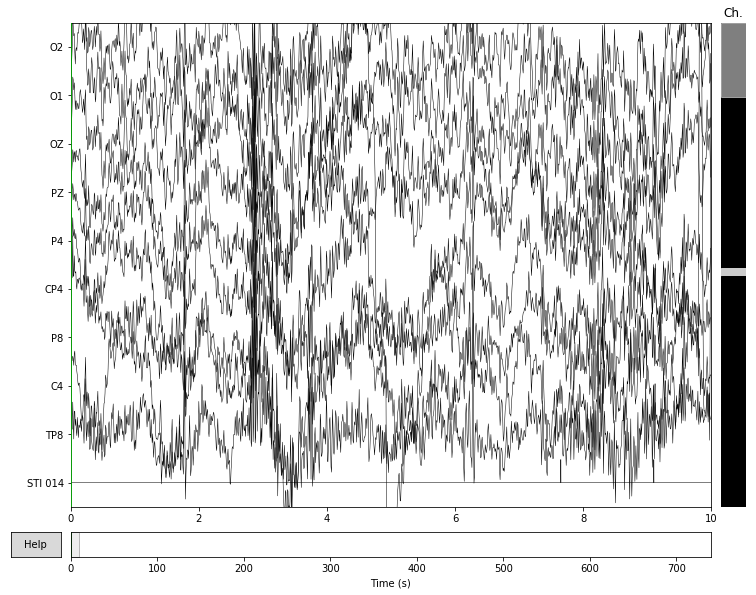

In [151]:
order = np.arange(data_raw.info['nchan'])
order[9] = 64  # We exchange the plotting order of two channels
order[64] = 9  # to show the trigger channel as the 10th channel.
data_raw.plot(n_channels=10, order=order, block=True)

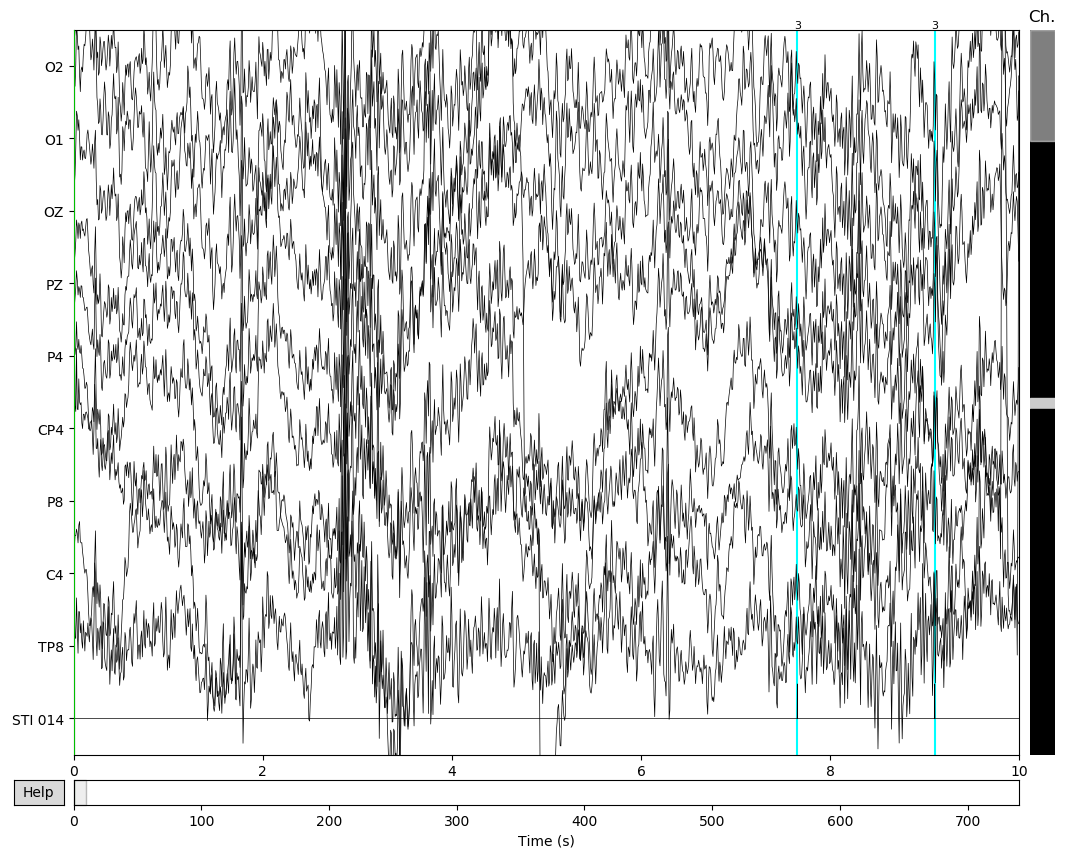

In [148]:
data_raw.plot(events=events, n_channels=10, order=order)